## BPM (BEAT PER MINUTE) CALCULATION FROM ECG (ELECTROCARDIOGRAPHY)  SIGNAL

ECG sensor records the electrical activities of heart using electrodes that can be detect tiny electrical change on skin. Below figure shows a normal ECG graph for one cardiac cycle and its segments and intervals. Shortly, cardiac cycle consists two parts. While PR interval is about atrial contradiction, QT  interval is about ventricular.During QRS complex, two ventricles activated from endocardium to epicardium. You can see more detailed info in [1],[3].
ECG signal is a non-stationary signal as almost all biological signals. Non-stationary signals are signals whose frequency changes in time [2].

![ECG signal of one cardiac cycle and its interval and segments.The P wave, QRS complex, ST segment and the T
wave](./images/ECG_signal.png)


Wavelet transform is a useful tool to deal with non-stationary signals. In this study, BPM or heart rate is found out by using continuous wavelet transform from ECG signal. 

\begin{eqnarray}
 CWT ^\psi _x (\tau ,s)=\Psi^\psi _x (\tau ,s) = \dfrac{1}{\sqrt{|s|}} \int ^\infty _{-\infty} x(t) \psi ^* (\dfrac{t-\tau}{s}) dt
 \label{for:cwt}
\end{eqnarray}

As seen in the above equation, the transformed signal is a function of two variables, 
the translation $\tau$ and scale $s$ parameters correspond to time and frequency respectively.  $\psi(t)$ is the transforming function, and it is called the mother wavelet [2]. The constant number $1/\sqrt{|s|}$ is for energy normalization purposes so that the transformed signal will have the same energy at every scale. 

Let's start coding. Firstly, call libraries that will be used in this study and load the ECG signal as a dataframe.'ecg_data' file contains only ECG signal values with 100 Hz frequency. We adding dataframe time column as below.

In [1]:
# heart rate by using ECG signal
# 15.10.2018 Manchester

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

columns = ['ECG']
dfA= pd.read_csv('ecg_data', header = None, names = columns)
frequence=100
time=range(0,len(dfA['ECG']*frequence))
time=[float(t)/frequence for t in time]
dfA['time']=time

/home/zer/.local/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


Let's show some part of data in time domain to see what we are dealing with. First 3 second are shown in below. 

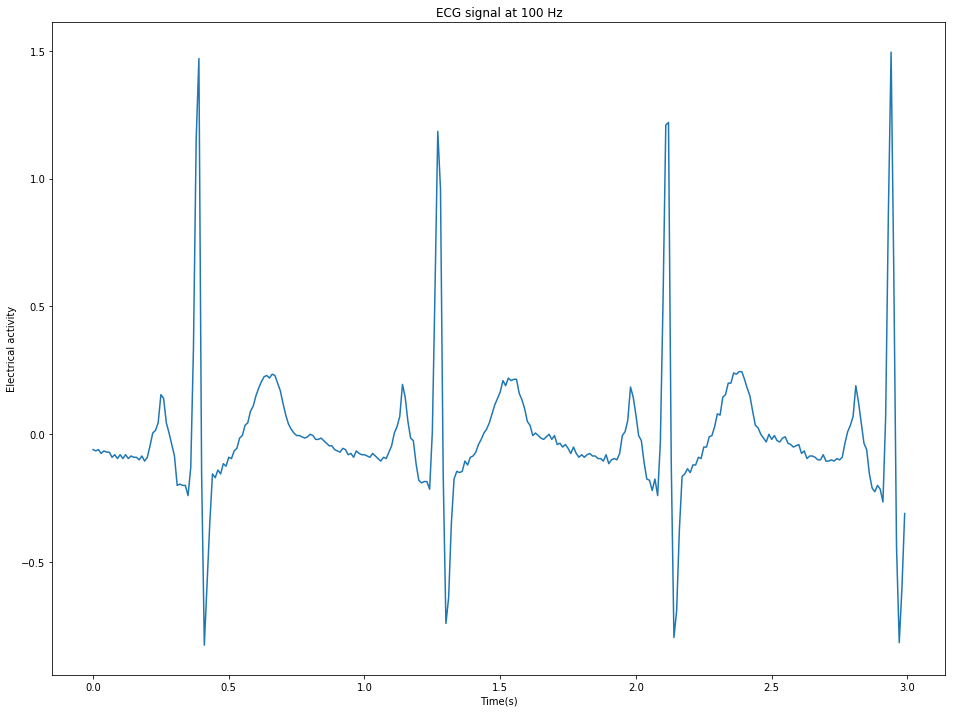

In [2]:
df=dfA[:3*frequence] 
plt.figure(figsize= (16,12))
plt.ylabel('Electrical activity')
plt.xlabel('Time(s)')
plt.plot(df['time'],df['ECG'])
plt.title('ECG signal at '+str(frequence) +' Hz')
plt.show()

As you see above, ECG signals is a series of cardiac cycles. Let's call cardiac cycle as CC. To calculate heart rate, we need to find the number of CC in one minute. In this study, to count the CCs, picks are detected by CWT function of scipy signal library. You can look for detail about this function here [[4](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.cwt.html)]. Mexican hat wavelet that is named as Ricker wavelet is used as mother wavelet function. $[1,100)$ range is used as scale interval. While lower scales are able to detect high frequency components, as the scale increases, the transform starts picking up the lower frequency components. 

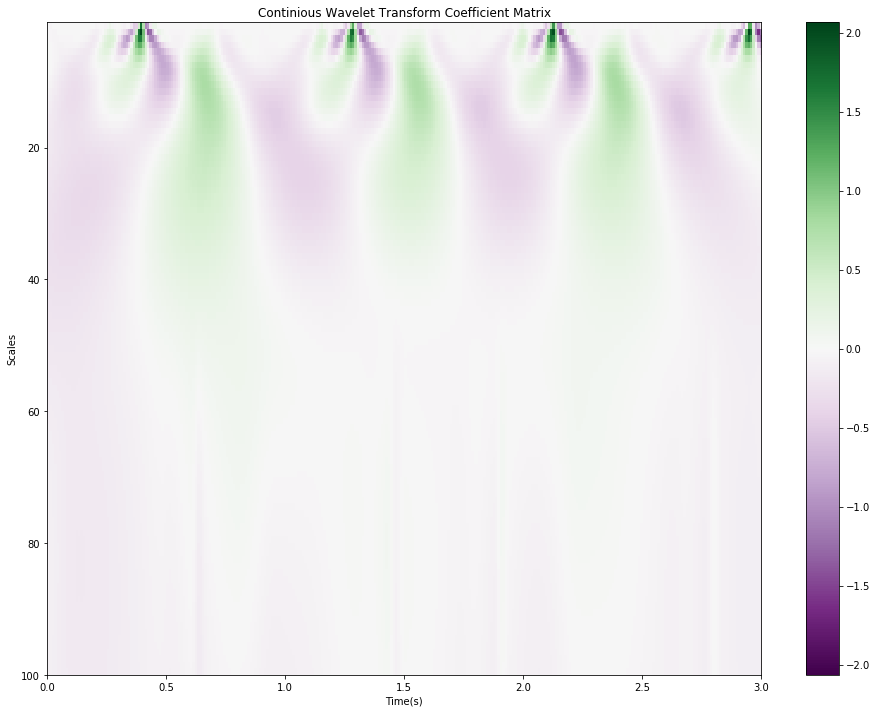

In [3]:
sig  = df['ECG']
widths = np.arange(1, 100)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
plt.figure(figsize= (16,12))
plt.ylabel('Scales')
plt.xlabel('Time(s)')
plt.title('Continious Wavelet Transform Coefficient Matrix')
plt.imshow(cwtmatr, extent=[0, 3, 100, 1], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.colorbar()
plt.show()

The wavelet transform gives good time and poor frequency resolution at low scales, and good frequency and poor time resolution at at high scales. You can examine below the CWT for every scale (that means also rows of CWT coefficient matrix) in range $[1,100)$. As the scale increase, the time resolution decreases.

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


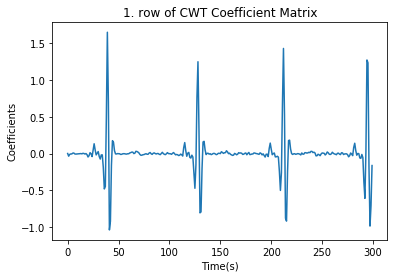

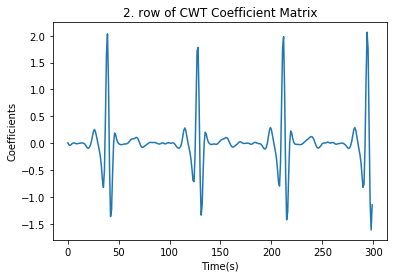

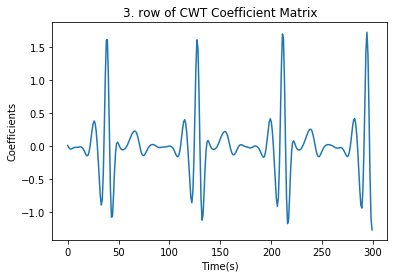

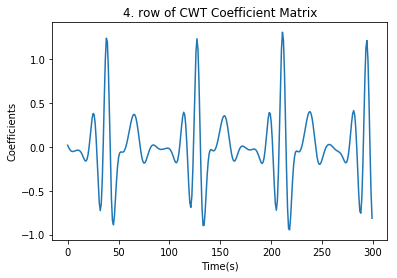

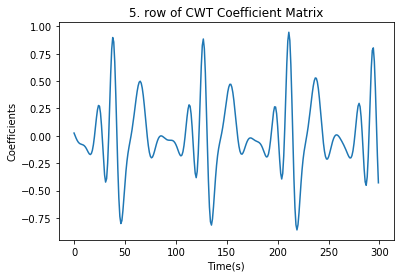

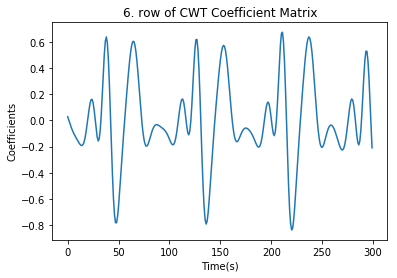

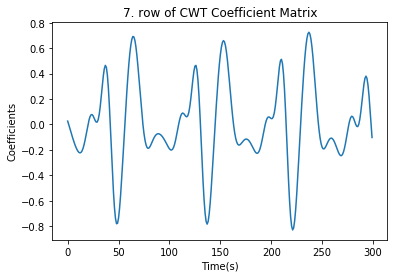

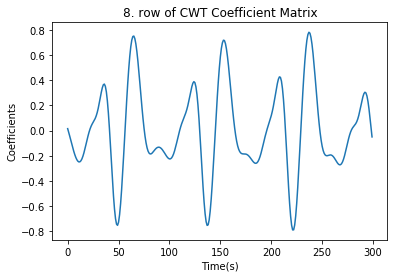

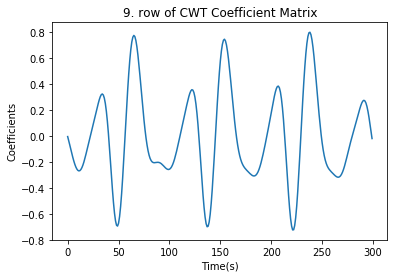

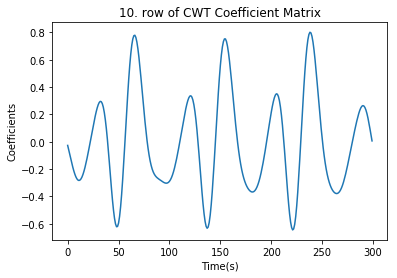

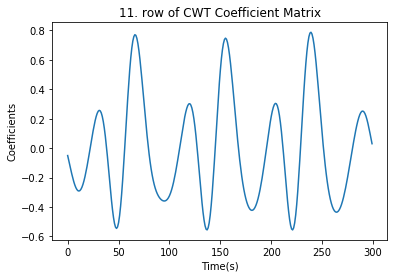

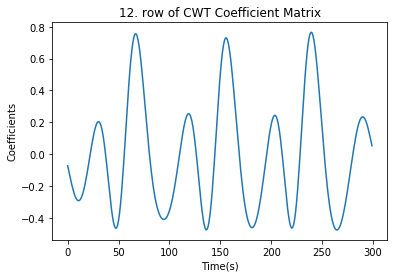

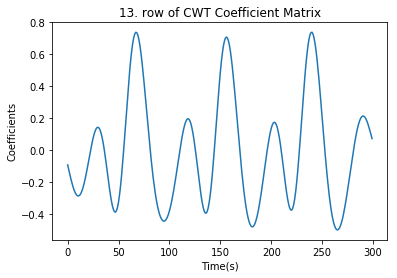

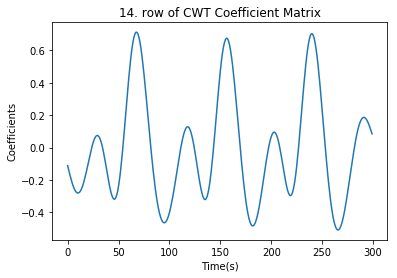

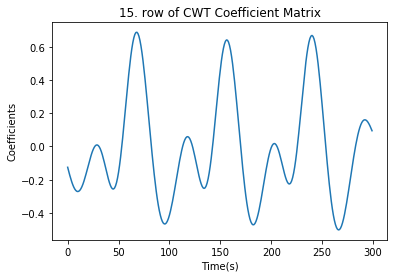

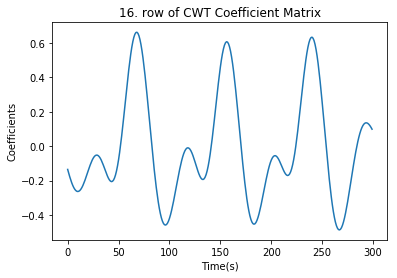

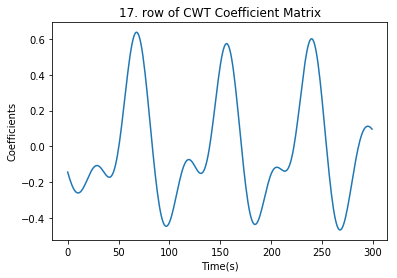

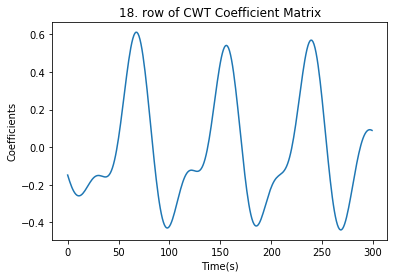

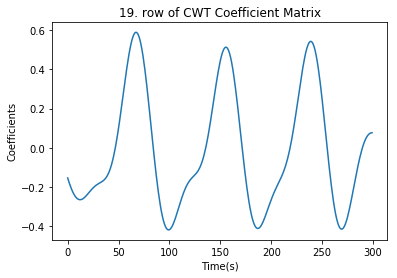

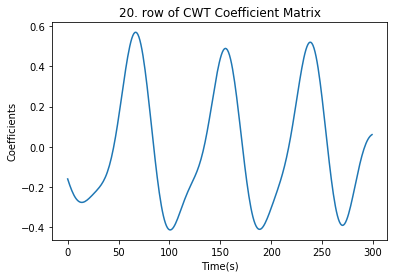

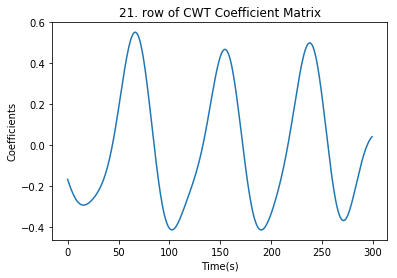

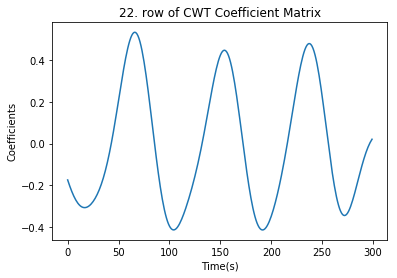

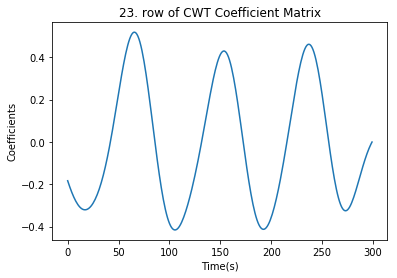

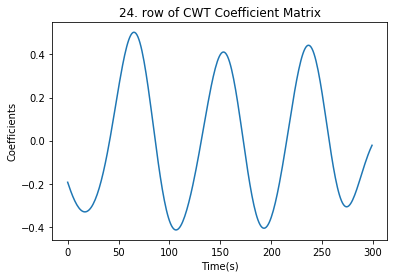

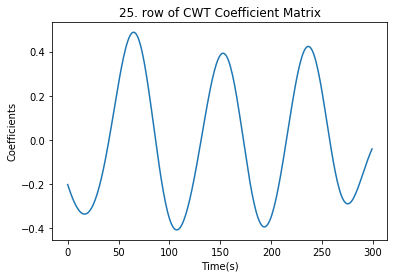

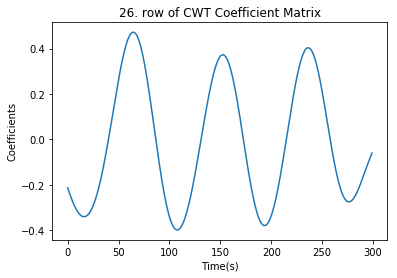

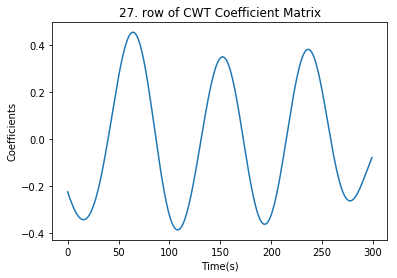

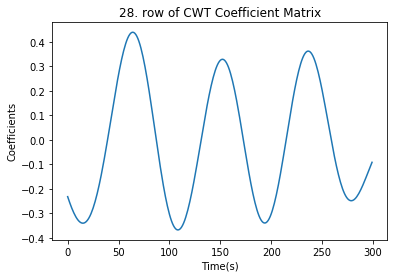

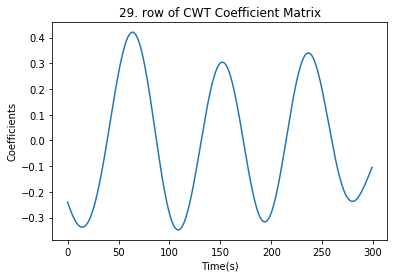

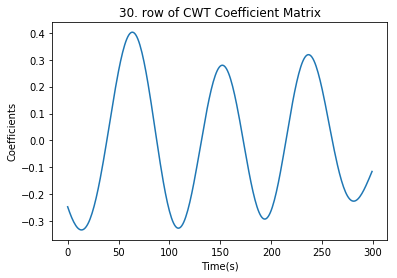

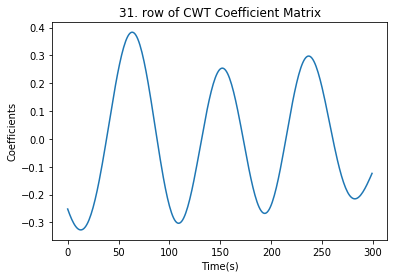

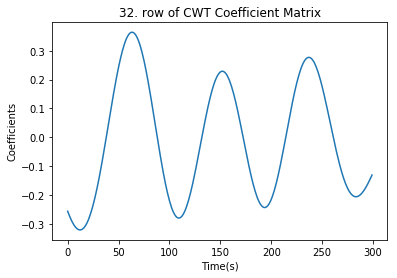

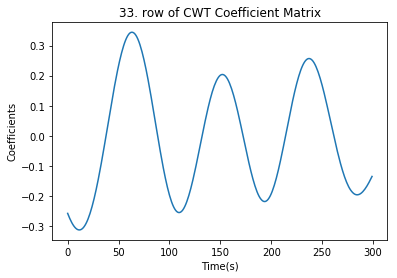

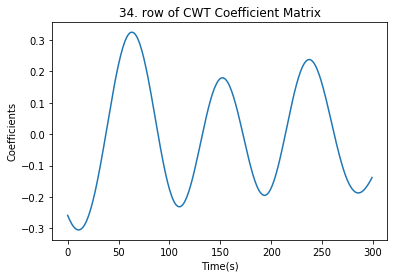

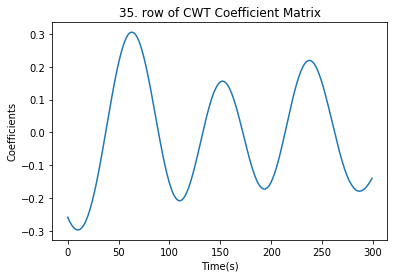

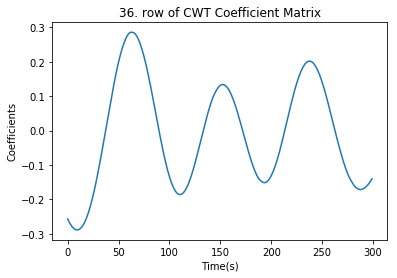

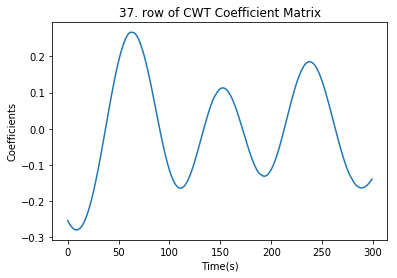

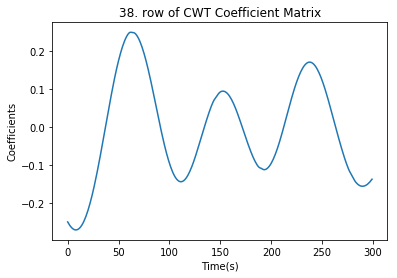

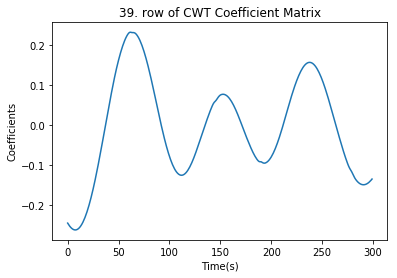

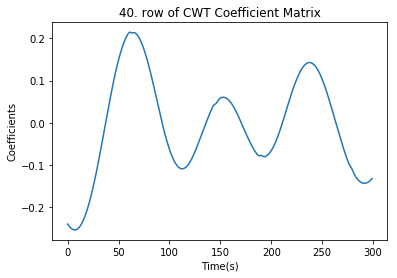

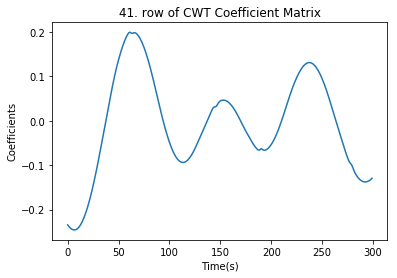

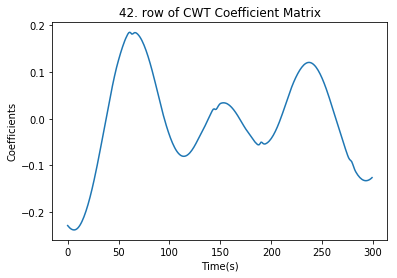

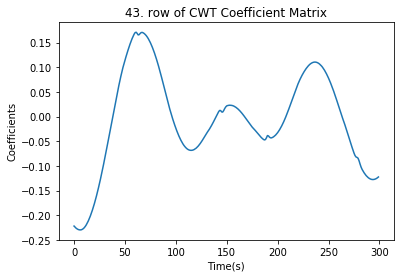

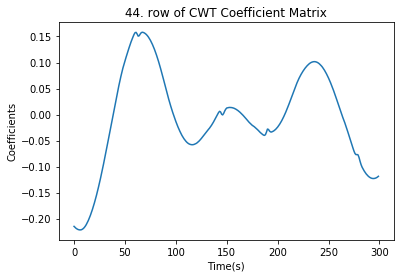

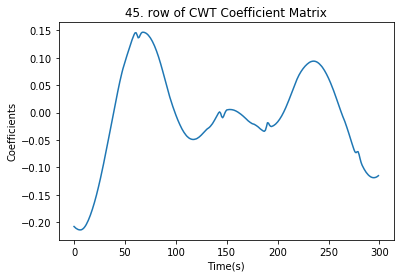

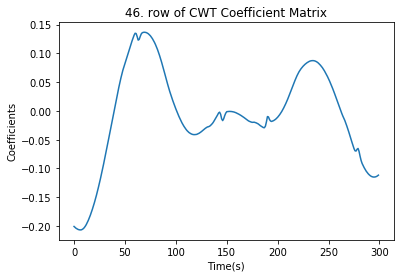

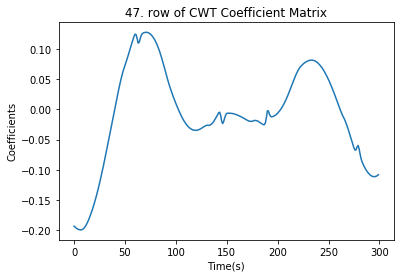

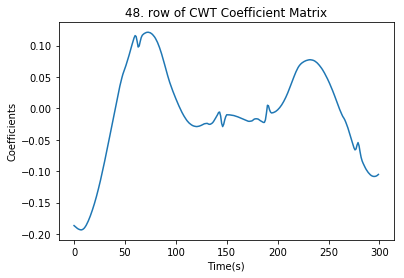

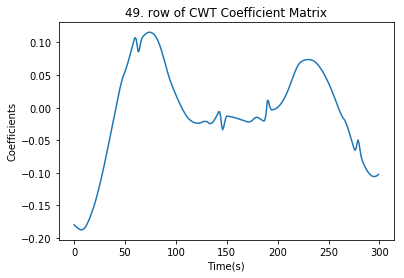

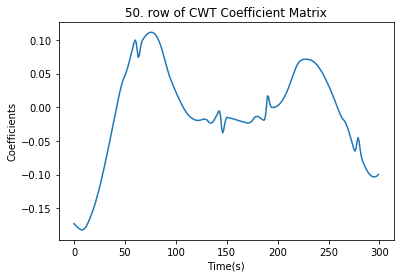

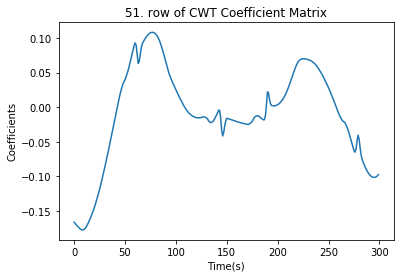

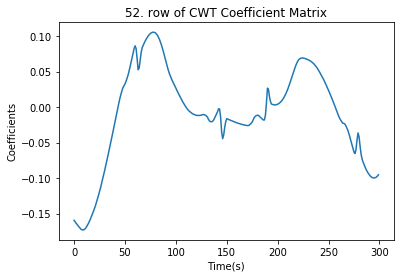

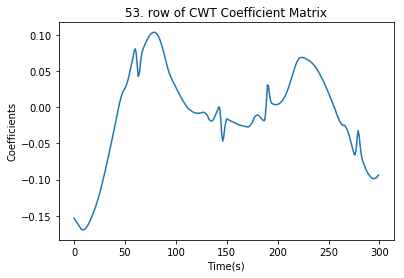

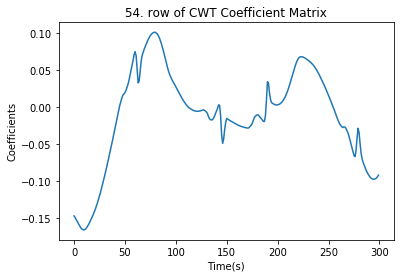

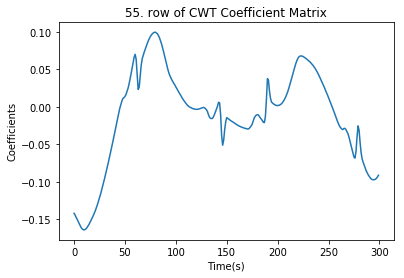

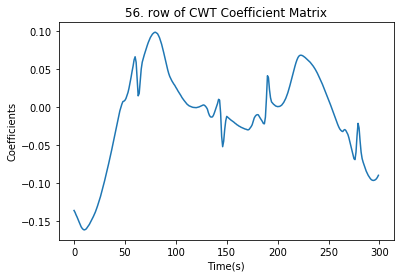

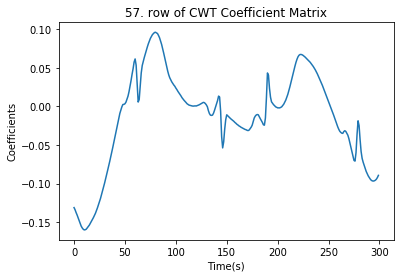

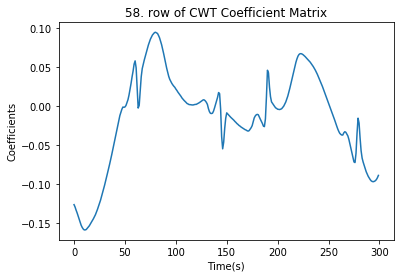

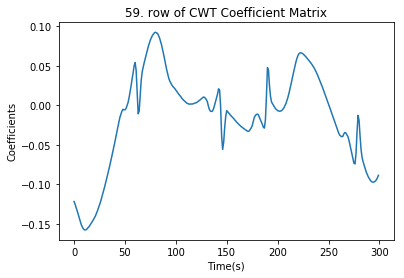

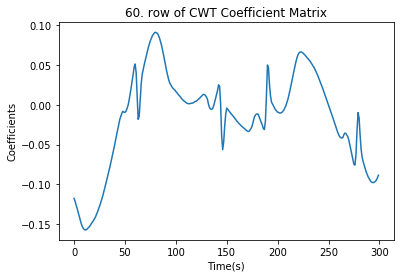

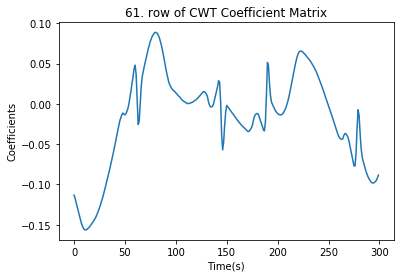

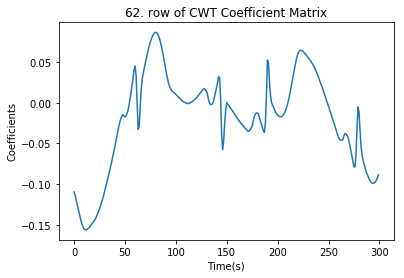

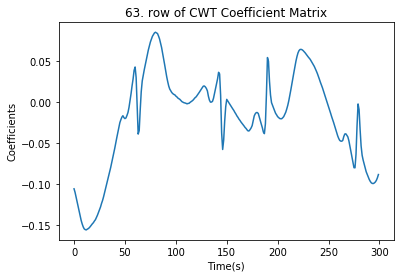

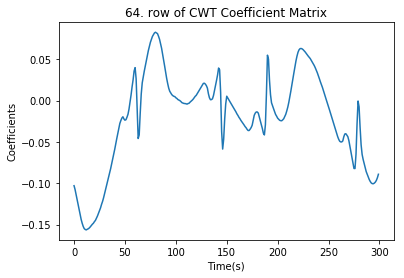

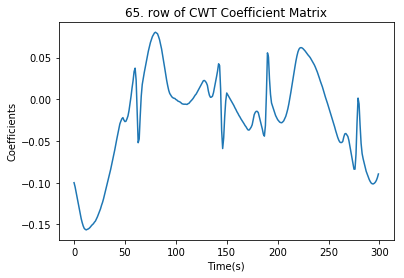

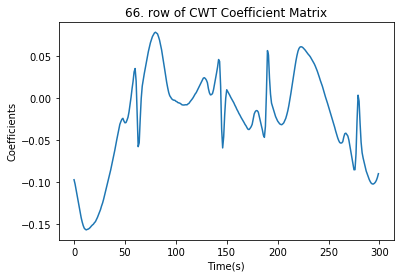

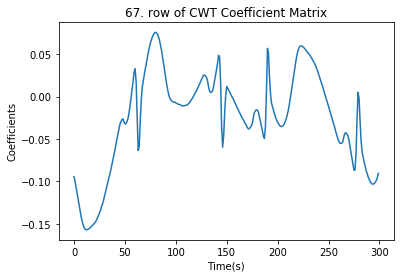

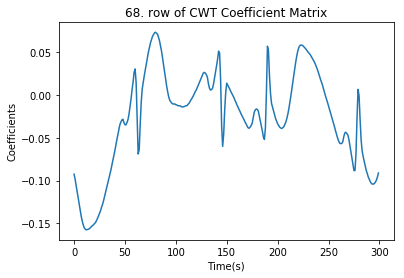

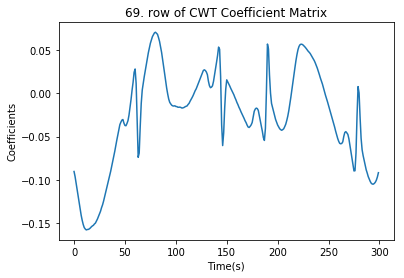

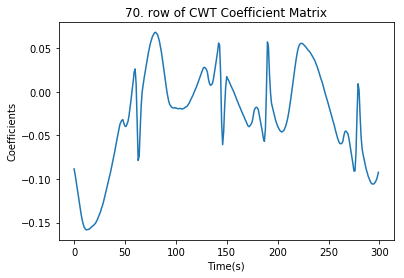

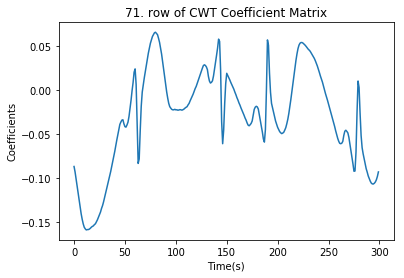

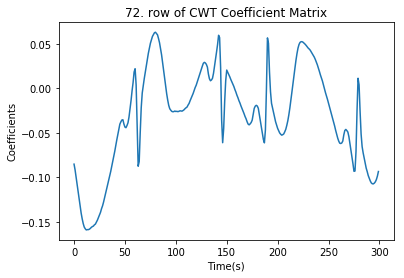

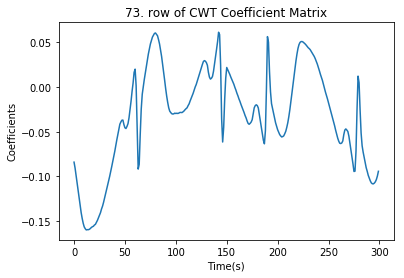

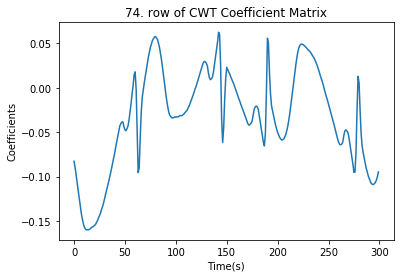

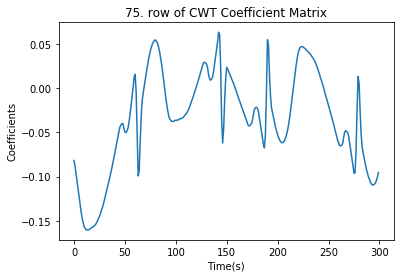

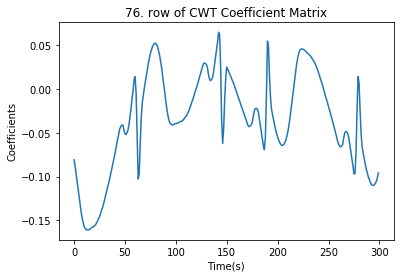

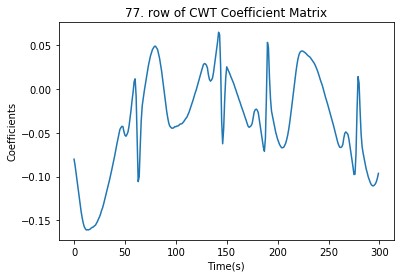

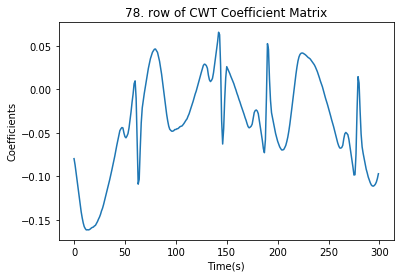

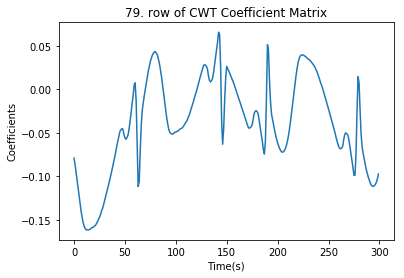

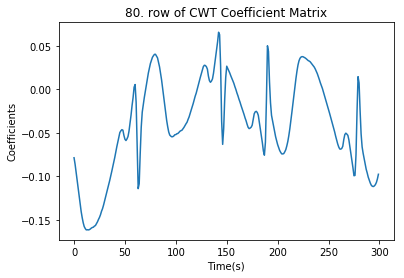

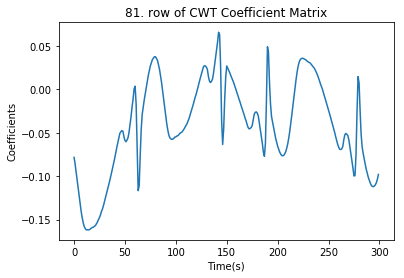

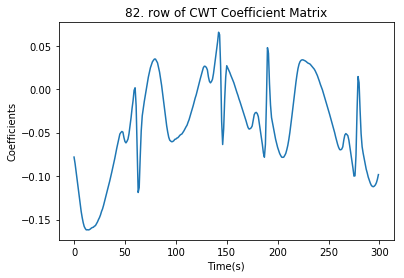

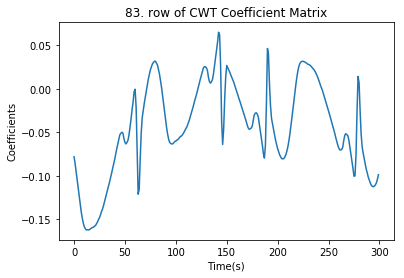

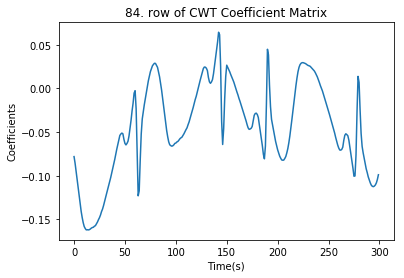

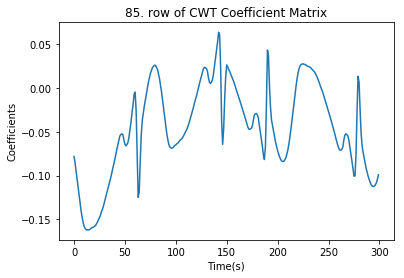

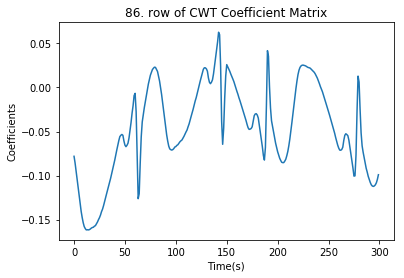

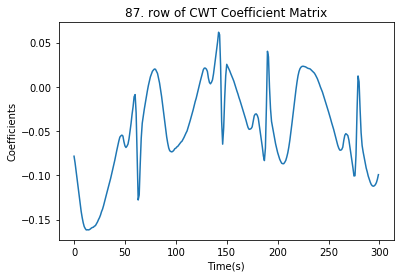

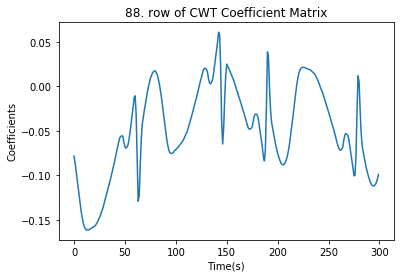

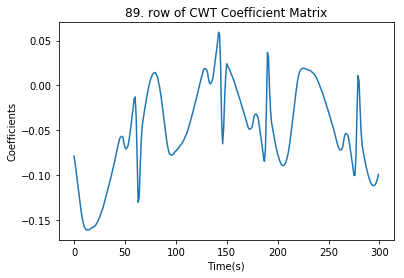

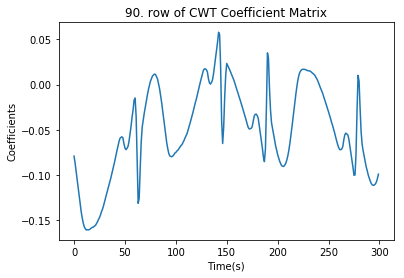

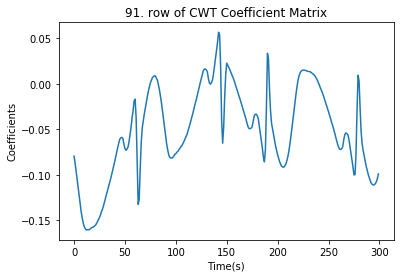

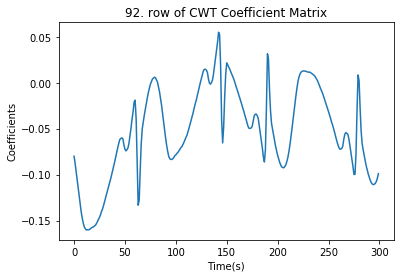

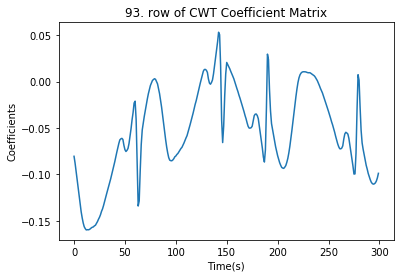

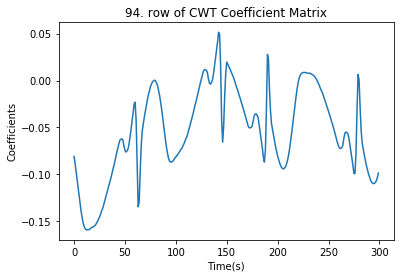

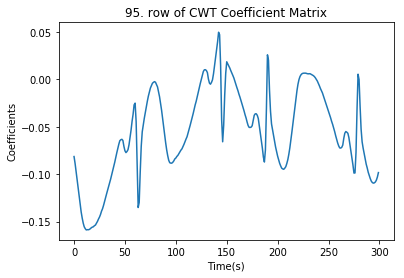

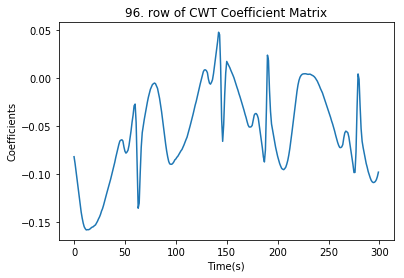

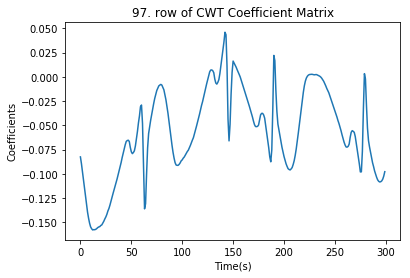

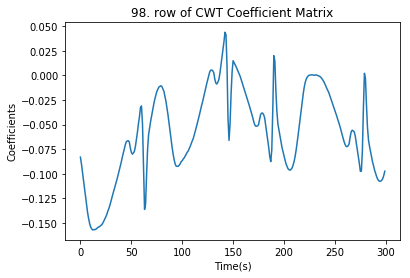

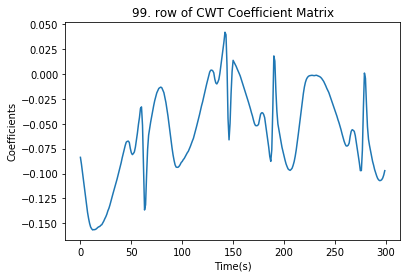

In [4]:
for i in range(cwtmatr.shape[0]):
    plt.figure()
    plt.plot(cwtmatr[i].tolist())
    plt.ylabel('Coefficients')
    plt.xlabel('Time(s)')
    plt.title(str(i+1)+'. row of CWT Coefficient Matrix')

In here, we will use the first row of the CWT coefficient matrix that gives the best time resolution. To get rid of dealing with minus values, square of this column as used to calculate mean. The obtained mean is used as the threshold to obtain most frequently changed points in ECG signal. Note that we used the threshold to only define the times that frequency is high.

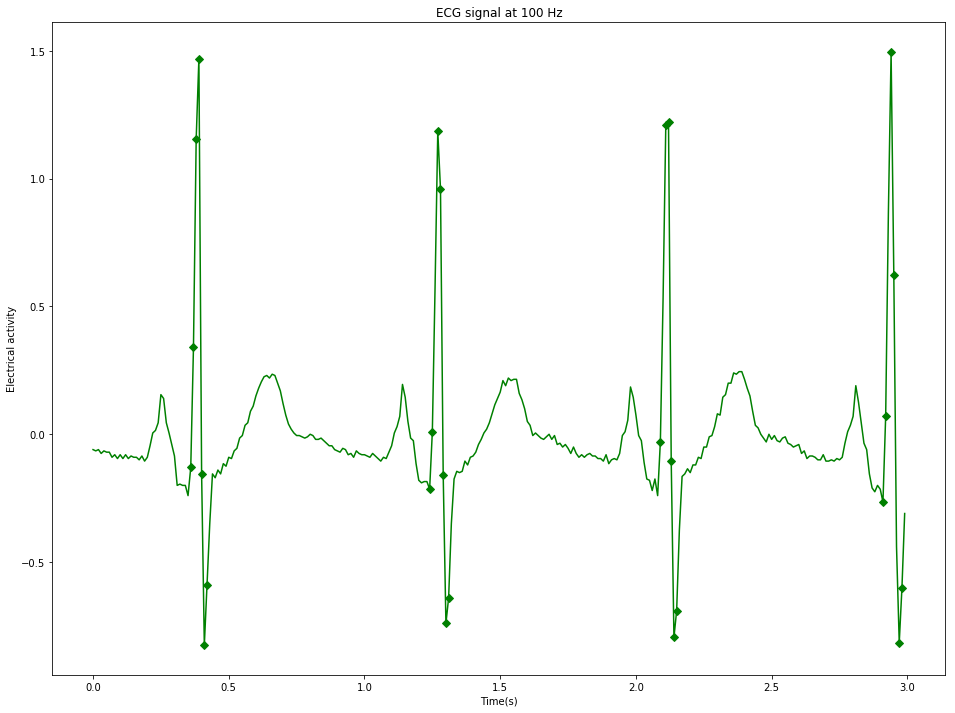

In [5]:
square_cwt_c0=[v**2 for v in cwtmatr[0].tolist()]
threshold=np.mean(square_cwt_c0)
marks=[]
for i,v in enumerate(square_cwt_c0):
    if v>threshold:
        marks.append(i)

plt.figure(figsize= (16,12))
plt.ylabel('Electrical activity')
plt.xlabel('Time(s)')
plt.plot(df['time'],df['ECG'],'-gD', markevery=marks)
plt.title('ECG signal at '+str(frequence) +' Hz')
plt.show()

The points that changes high frequently on ECG signal is obtained We will just need to find out peaks now. If the previous point and the next point lower than current point, the current point is a peak.

4  beats in  2.99 seconds


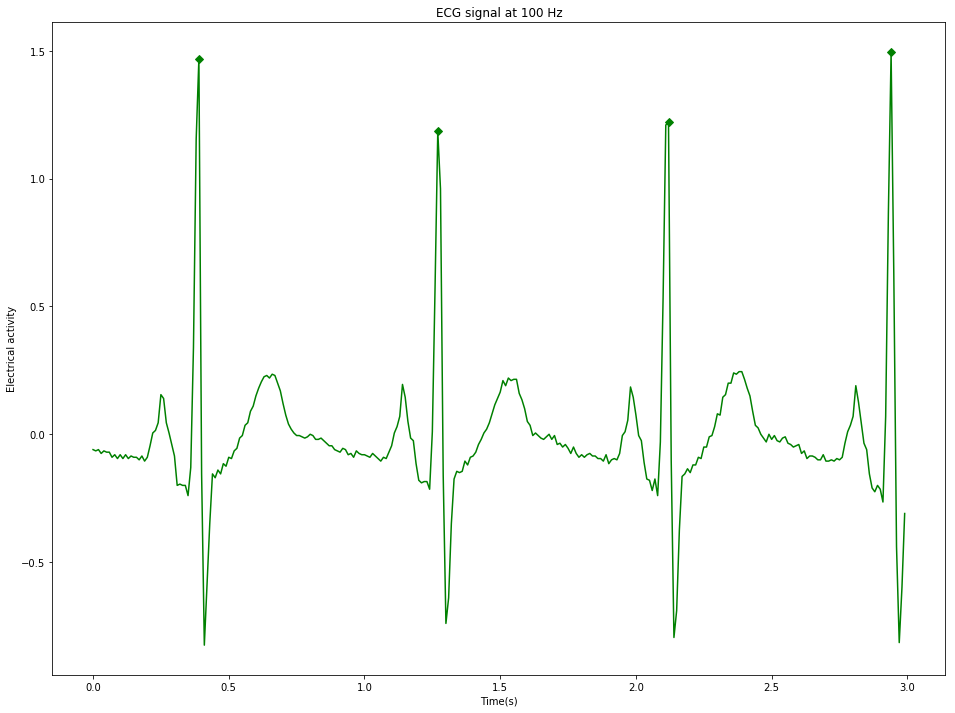

In [6]:
peaks=[]
beats=0
for i,m in enumerate(marks):
    try:
        if df['ECG'][marks[i-1]]<df['ECG'][m] and df['ECG'][marks[i+1]]<df['ECG'][m]: 
            peaks.append(m)
            beats+=1
    except:
        continue
print str(beats)," beats in ",str(max(df['time'])-min(df['time'])), "seconds" 
plt.figure(figsize= (16,12))
plt.ylabel('Electrical activity')
plt.xlabel('Time(s)')
plt.plot(df['time'],df['ECG'],'-gD', markevery=peaks)
plt.title('ECG signal at '+str(frequence) +' Hz')
plt.show()

As you can see above, we have obtained all peak points in ECG signals that gives info about the cardiac cycle interval. Let's define a function that do all above procedures for showing BPM by time. In this study, 6 seconds technique is used to calculate BPM as default. The 'T' input shows the window width that counted to calculate approximate beat count during one minute. When you increase 'T', BPM resolution becomes better.  

In [7]:
def calculateBPM(dfA, T=6):
# as input, dfA is a dataframe with two column; ECG and time(seconds)
# this function returns the BPMs for seconds
    BPMs=[]
    frequence=dfA.index[dfA['time'] == dfA['time'][0]+1].tolist()[0]-dfA.index[dfA['time'] == dfA['time'][0]].tolist()[0]
    for k in range((dfA.shape[0]/frequence)-T+1):
        df=dfA[k*frequence:(k+T)*frequence]
        sig  = df['ECG']
        widths = np.arange(1, 2)
        cwtmatr = signal.cwt(sig, signal.ricker, widths)
        square_cwt_c0=[v**2 for v in cwtmatr[0].tolist()]
        threshold=np.mean(square_cwt_c0)
        marks=[]
        for i,v in enumerate(square_cwt_c0):
            if v>threshold:
                marks.append((k*frequence)+i)
        peaks=[]
        beats=0
        #print marks, df['ECG']
        for i,m in enumerate(marks):
            #print i
            if i==0 or i==len(marks)-1:
                continue
            if df['ECG'][marks[i-1]]<df['ECG'][m] and df['ECG'][marks[i+1]]<df['ECG'][m]: 
                peaks.append(m)
                beats+=1
           
        #print 'for ',k,'. second;',str(beats)," beats in ",str(max(df['time'])-min(df['time'])), "seconds" 
        BPMs.append(beats*(60/T))
    return BPMs

Let's use this function and plot the BPM, time graph.

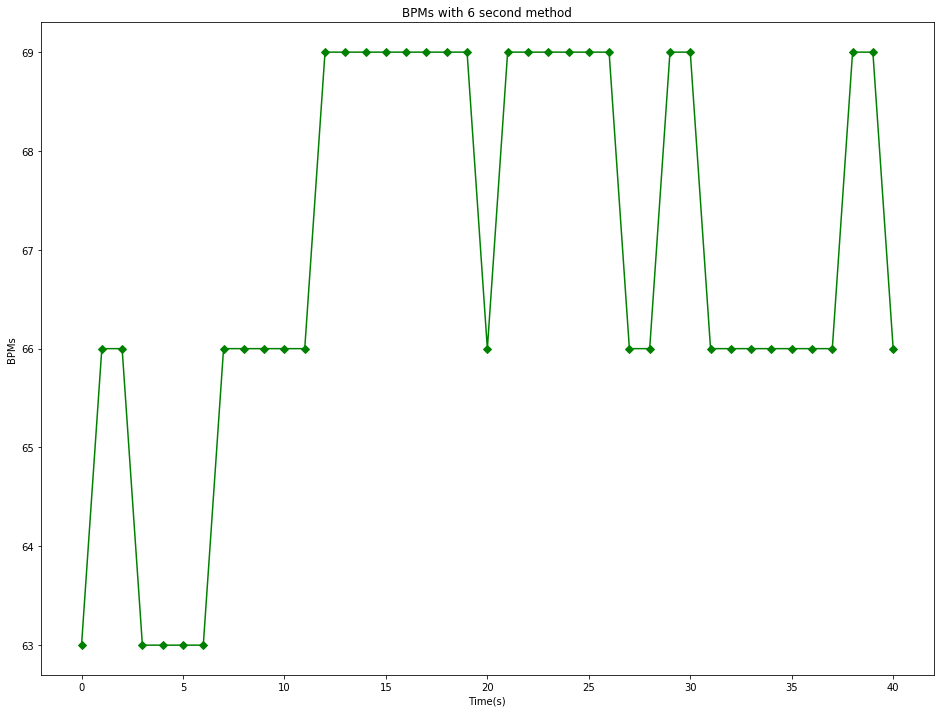

In [8]:
BPMs=calculateBPM(dfA,20)

plt.figure(figsize= (16,12))
plt.ylabel('BPMs')
plt.xlabel('Time(s)')
plt.plot(BPMs,'-gD')
plt.title('BPMs with 6 second method')
plt.show()

## Refences

[1] Mary Boudreau Conover, Understanding Electrocardiography - Seventh Edition. Missouri: Mosby Publications, 1996. 

[2] POLIKAR, Robi. The wavelet tutorial. 1996.

[3] https://www.youtube.com/watch?v=y0tJz-77vDE, 04.10.2018

[4] https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.cwt.html, 04.10.2018